In [52]:
M = 30
N_train = 50000
EPOCHS = 500
fn = 'triangle_test_large_long.keras'

=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)


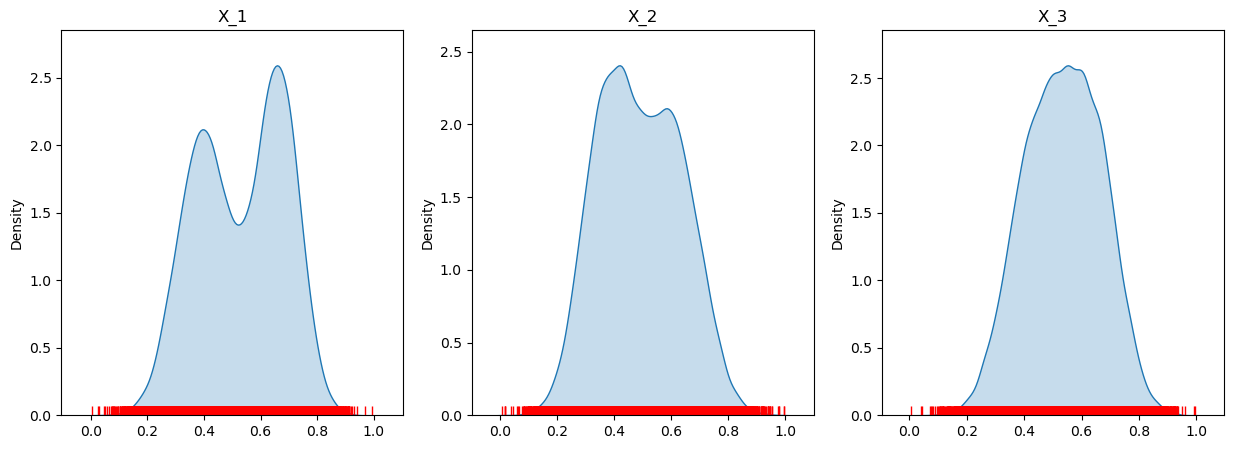

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from cflow.masked_linear import create_masks_np, LinearMasked, create_theta_tilde_maf, dag_loss
from cflow.utils import scale_df

######### DGP #########
def dgp(n_obs):
    print("=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)")
    flip = np.random.choice([0, 1], n_obs)
    X_1 = flip * np.random.normal(-2, np.sqrt(1.5), n_obs) + (1 - flip) * np.random.normal(1.5, 1, n_obs)
    X_2 = -X_1 + np.random.normal(size=n_obs)
    X_3 = X_1 + 0.25 * X_2 + np.random.normal(size=n_obs)

    dat_s = np.column_stack((X_1, X_2, X_3))
    dat_tf = tf.constant(dat_s, dtype=tf.float32)

    scaled = scale_df(dat_tf) * 0.99 + 0.005

    A = np.array([[0, 1, 1], [0, 0, 1], [0, 0, 0]])
    return {'df_orig': dat_tf, 'df_scaled': scaled, 'A': A}

# Generate training data
train = dgp(N_train)
# Give summary statistics of df_scaled
import seaborn as sns

# Plot the KDEs of the training data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    sns.kdeplot(train['df_scaled'][:, i], ax=axs[i], fill=True)
    sns.rugplot(train['df_scaled'][:, i], ax=axs[i], color='r')
    axs[i].set_title(f"X_{i+1}")
plt.show()

In [54]:
# Transpose the adjacency matrix
adjacency = np.transpose(train['A']) == 1 #Needs to be a boolean matrix
# Define layer sizes
hidden_features = (2,2)
layer_sizes = (adjacency.shape[1], *hidden_features, adjacency.shape[0])
print(f"A: {adjacency}, Layer sizes: {layer_sizes}")
masks = create_masks_np(adjacency = adjacency, hidden_features=hidden_features)
param_model = create_theta_tilde_maf(adjacency=adjacency, order=M+1, layer_sizes=layer_sizes, masks=masks)
from keras.utils import plot_model
print(f"Output of untrained model {param_model(tf.constant(train['df_scaled'], dtype=tf.float32)).shape}")  
if (M<4):
    plot_model(param_model, to_file='model_graph.png', show_shapes=True)
    

A: [[False False False]
 [ True False False]
 [ True  True False]], Layer sizes: (3, 2, 2, 3)
Output of untrained model (50000, 3, 31)


In [55]:
optimizer = Adam()
param_model.compile(optimizer=optimizer, loss=dag_loss)
#param_model.summary()
# Evaluate the untrained model
eval_result = param_model.evaluate(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   batch_size=32)

1563/1563 [==============================] - 2s 1ms/step - loss: 1.7485


In [56]:
# Fit the model if the file  fn does not exist
import os
if not os.path.exists(fn):
    history = param_model.fit(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                            y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                            epochs=EPOCHS, 
                            verbose=True)

Epoch 1/500


1563/1563 [==============================] - 11s 4ms/step - loss: 0.8082
Epoch 2/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.0094
Epoch 3/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.2553
Epoch 4/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.3829
Epoch 5/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.4809
Epoch 6/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.5533
Epoch 7/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.6046
Epoch 8/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.6461
Epoch 9/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.6814
Epoch 10/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.7102
Epoch 11/500
1563/1563 [==============================] - 6s 4ms/step - loss: -0.7336
Epoch 12/500
1563/1563 [==============================] - 6s 4ms/step - los

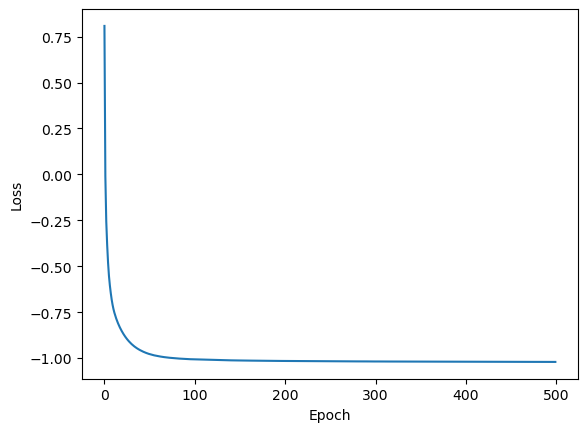

In [57]:
# Plot training history
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [58]:
eval_result = param_model.evaluate(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   batch_size=32)
print(f"Original model loss: {eval_result}")

1563/1563 [==============================] - 2s 947us/step - loss: -1.0209
Original model loss: -1.020885944366455


In [59]:
# Save the model
param_model.save(fn)

In [60]:
# Loading the model
loaded_model = tf.keras.models.load_model(
    fn, 
    custom_objects={
        'LinearMasked': LinearMasked,
        'custom_loss': dag_loss
    }
)
eval_result_loaded = loaded_model.evaluate(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                           y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                           batch_size=32)
print(f"Loaded model loss: {eval_result_loaded}")

1563/1563 [==============================] - 2s 1ms/step - loss: -1.0209
Loaded model loss: -1.020885944366455
